<a href="https://colab.research.google.com/github/arminsoltan/mohaymen/blob/development/Phase02/Intel_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import torchvision
import torch
from torchvision import transforms
import pandas as pd
import warnings
import os
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor,Resize,Normalize
import numpy as np

In [108]:
warnings.filterwarnings("ignore")

In [109]:
# !unzip "/content/drive/MyDrive/dataset/Intel.zip" -d "/content/"

In [110]:
# Hyper-parameters
num_epochs = 3
batch_size = 10
learning_rate = 0.001


In [111]:
# transform = transforms.Compose[transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
train_dir = '/content/Intel/seg_train'
test_dir = '/content/Intel/seg_test'
outcomes = os.listdir(train_dir)
print(outcomes)

['forest', 'sea', 'street', 'mountain', 'buildings', 'glacier']


In [112]:
nums = {}
for outcome in outcomes:
  nums[outcome] = len(os.listdir(train_dir + '/' + outcome))
image_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
image_per_class

,no. of images
forest,2271
sea,2274
street,2382
mountain,2512
buildings,2191
glacier,2404


In [113]:
nums_test = {}
outcomes_test = os.listdir(test_dir)
for outcome in outcomes_test:
  nums_test[outcome] = len(os.listdir(test_dir + '/' + outcome))
test_image_per_class = pd.DataFrame(nums_test.values(), index=nums_test.keys(), columns=["no. of test images"])
test_image_per_class

,no. of test images
forest,474
sea,510
street,501
mountain,525
buildings,437
glacier,553


In [114]:
# from google.colab import drive
# drive.mount('/content/drive')

In [115]:
transform = transforms.Compose([Resize((224,224)),
                         ToTensor(),
                         Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])])

In [116]:
train_data = ImageFolder(root=train_dir, transform=transform)
test_data = ImageFolder(root=test_dir, transform=transform)

In [117]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


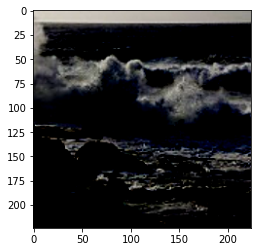

In [118]:
samples, labels = iter(train_dataloader).next()
sample = samples[0]
sample = np.transpose(sample, (1, 2, 0))
plt.imshow(sample)

In [119]:
conv1 = nn.Conv2d(3, 6, 5)
print(samples.shape)
x = conv1(samples)
print(x.shape)
pool1 = nn.MaxPool2d(2, 2)
x = pool1(x)
print(x.shape)
conv2 = nn.Conv2d(6, 16, 5)
x = conv2(x)
print(x.shape)
x = pool1(x)
print(x.shape)
# x = x.view(-1, 16 * 106 * 106)
# print(x.shape)


torch.Size([10, 3, 224, 224])
torch.Size([10, 6, 220, 220])
torch.Size([10, 6, 110, 110])
torch.Size([10, 16, 106, 106])
torch.Size([10, 16, 53, 53])


In [120]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 53 * 53, 53 * 53)
    self.fc2 = nn.Linear(53 * 53, 10 * 10)
    self.fc3 = nn.Linear(10 * 10, 6)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 53 * 53)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [121]:
PATH = "/content/state_dict_model.pt"

In [122]:
model = ConvNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

model.train()

n_total_steps = len(train_dataloader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_dataloader):

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
torch.save(model.state_dict(), PATH)




In [123]:
model = ConvNet()
model.load_state_dict(torch.load(PATH))
model.eval()

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(6)]
  n_class_samples = [0 for i in range(6)]

  for images, labels in test_dataloader:
    outputs = model(images)

    _, predicted = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (labels == predicted).sum().item()

    for i in range(batch_size):
      label = labels[i]
      pred = predicted[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1
  acc = 100.0 * n_correct / n_samples
  print(f"accuracy for this model {acc:.4f}")
  
  

accuracy for this model 60.6667
